## Learning Dynamics and Lyapunov function for Inverted Pendulum

In [ ]:
# To install dReal, if you use Google CoLab
# If not CoLab, command out
import pkgutil
if not pkgutil.find_loader("dreal"):
  !curl https://raw.githubusercontent.com/dreal/dreal4/master/setup/ubuntu/18.04/install.sh | bash
  !pip install dreal --upgrade

In [3]:
# -*- coding: utf-8 -*-
from dreal import *
from Functions import *
import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dynamical system

In [5]:
def f_value(x,u):
    #Dynamics
    y = []
    G = 9.81  # gravity
    L = 0.5   # length of the pole 
    m = 0.15  # ball mass
    b = 0.1   # friction
    
    y = (m*G*L*torch.sin(x[:,0])- b*x[:,1] + u[:,0]) / (m*L**2)
    
    return y.reshape(len(y),1)

## NN for the dynamics

In [6]:
# NN for dynamics
class DNet(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden1,n_output):
        super().__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden1)
        self.layer2 = torch.nn.Linear(n_hidden1,n_output)
        self.to(device) 
        

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = self.layer2(h_1)
        return out

## Learning the dynamics with NNs

In [ ]:
# training dataset 2
xx = np.linspace(-5.,5., 2501, dtype = float)
X = []
for i in range(0,len(xx)): 
    for j in range(0,len(xx)):
        X.append([xx[j],xx[i]])
        
X = torch.tensor(X)
X = X.float()

u_t = torch.Tensor(len(X), 1).uniform_(-25., 25.) 
x_train = torch.cat((X,u_t),1)
# target
t_f = f_value(X,u_t)

In [35]:
with torch.no_grad():
    torch.cuda.empty_cache()

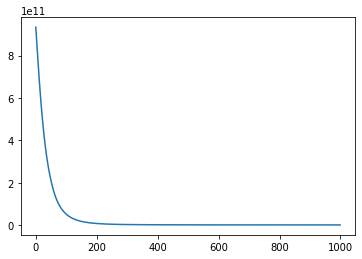

In [ ]:
# define parameters
max_iter = 1000
losses = []
# NN: 1 hidden layers with 200 neurons each layer 
net = DNet(n_input = 3, n_hidden1 = 200,  n_output = 1)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.05)
loss_func = torch.nn.MSELoss(reduction='sum')

# training
for epoch in tqdm(range(max_iter)):
    x_train = x_train.to(device)
    t_f = t_f.to(device)
    y_nn = net(x_train)
    loss = loss_func(y_nn,t_f)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)

In [ ]:
losses[-1]

2404.6484375

100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s]


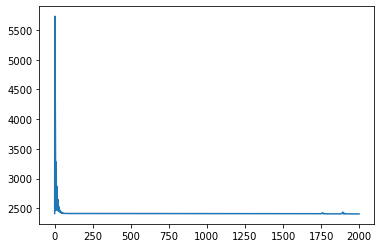

In [ ]:
# train more epoches
with torch.no_grad():
    torch.cuda.empty_cache()

net = net.to(device)
losses = []
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00002)
loss_func = torch.nn.MSELoss(reduction='sum')
# t = f_value(x_f)  # actual dynamics
# t = t.float()
for epoch in tqdm(range(2000)):
    x_train = x_train.to(device)
    t_f = t_f.to(device)
    y_nn = net(x_train)
    loss = loss_func(y_nn,t_f)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)

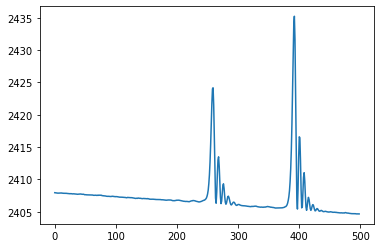

In [ ]:
plt.plot(losses[-500:-1])

In [12]:
# generate actual dataset
r = 4 # region of interest
N_l = 2001
xl = np.linspace(-r,r,N_l, dtype = float)
x_l = []
for i in range(0,N_l): 
    for j in range(0,len(xl)):
        x_l.append([xl[j],xl[i]])

x_l = torch.tensor(x_l)
x_l = x_l.float()

# target
u_bdd = 20.  # bound for input

u_l = torch.Tensor(len(x_l), 1).uniform_(-u_bdd, u_bdd) 
t_l = f_value(x_l,u_l)
x_bdd = torch.cat((x_l,u_l),1)

In [29]:
x_bdd = x_bdd.to(device)
t_l = t_l.to(device)
net = net.to(device)
y_l = net(x_bdd)

# maximum of loss
# loss_all = torch.norm(y_l-t_l, dim = 1)
dist = y_l-t_l
loss_all = torch.linalg.norm(dist, float('inf'))
torch.max(loss_all)

tensor(0.0691, device='cuda:0', grad_fn=<MaxBackward1>)

In [34]:
dist.shape

torch.Size([4004001, 1])

In [7]:
# save the fNN
# torch.save(fnet.state_dict(), 'PF_fnet514.pt')
# torch.save(net.cpu(), 'IP_fnet515.pt')

# load fNN from a file
net = torch.load('IP_fnet515_12am.pt').to(device)

RuntimeError: ignored

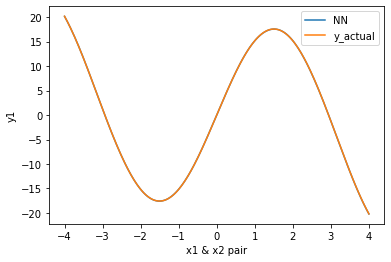

In [11]:
## dataset for plot
N_p = 300
xp = np.linspace(-4,4,N_p, dtype = float).reshape(N_p,1)
xx = np.linspace(-2,2,N_p, dtype = float).reshape(N_p,1) # fixed x2

for n in range(1): # for dim n
    xp = np.concatenate((xp,xx), axis=1 ) 

xp = torch.tensor(xp)

U = np.linspace(-2,2,N_p, dtype = float).reshape(N_p,1) # fixed input u
U = torch.tensor(U)
U0 = torch.zeros(N_p,1)

Xp = torch.cat((xp,U), 1)    
Xp = Xp.float()

Xp_0 = torch.cat((xp,U0), 1)    
Xp_0 = Xp_0.float()

Xp_0 = Xp_0.to(device)
y_0 = net(Xp_0)
t_p0 = f_value(xp,U0)
t_p0 = t_p0.to(device)
# plot for f1 and f2 with u = 0
with torch.no_grad():
    plt.figure(1)
    plt.plot(xp.cpu()[:,0],y_0.cpu()[:,0],label='NN')
    plt.plot(xp.cpu()[:,0],t_p0.cpu()[:,0], label='y_actual')
    plt.legend(loc = 0)
    plt.xlabel('x1 & x2 pair')
    plt.ylabel('y1')


y = net(Xp)
t_p = f_value(xp,U)
# plot for f1 and f2 with u != 0
with torch.no_grad():
    plt.figure(2)
    plt.plot(xp.cpu()[:,0],y.cpu()[:,0],label='NN')
    plt.plot(xp.cpu()[:,0],t_p.cpu()[:,0], label='y_actual')
    plt.legend(loc = 0)
    plt.xlabel('x1')
    plt.ylabel('f')


## Learned dynamics

In [9]:
def f_learned(x,u):
    X = torch.cat((x,u),1)
    f = net(X)
    x1 = x[:,1].reshape(len(x),1)
    y = torch.cat((x1,f),1)
    return y

## Neural network model
Building NN with random parameters for Lyapunov function and initializing parameters of NN controller to LQR solution

LQR solution is obtained by minimizing the cost function J = ∫(xᵀQx + uᵀRu)dt, where Q is 2×2 identity matrix and R is 1×1 identity matrix

In [12]:
class Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output,lqr):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)
        self.control.weight = torch.nn.Parameter(lqr)
        self.to(device) 

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = 20*sigmoid(self.control(x))
        return out,u

## Parameters

In [22]:
'''
For learning 
'''
N = 500             # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  
x = torch.Tensor(N, D_in).uniform_(-4, 4)           
x_0 = torch.zeros([1, 2])

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
G = 9.81 
l = 0.5  
m = 0.15
b = 0.1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0 # -5e-3 # typically this is 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.4
ball_ub = 4

## Learning and Falsification of Lyapunov function

In [23]:
out_iters = 0
valid = False
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    lqr = torch.tensor([[-23.58639732,  -5.31421063]])    # lqr solution
    model = Net(D_in,H1, D_out,lqr)
    L = []
    i = 0 
    t = 0
    max_iters = 3000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    f_w1 = net.layer1.weight.data.cpu().numpy()
    f_w2 = net.layer2.weight.data.cpu().numpy()
    f_b1 = net.layer1.bias.data.cpu().numpy()
    f_b2 = net.layer2.bias.data.cpu().numpy()

    while i < max_iters and not valid: 
        x = x.float()
        x = x.to(device)
        V_candidate,u = model(x)
        x_0 = x_0.to(device)
        X0,u0 = model(x_0)
        f = f_learned(x,u)
        # f = f_value(x,u)
        Circle_Tuning = Tune(x)
        Circle_Tuning = Circle_Tuning.to(device)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)

        # dVdx = torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
        #                     *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight)

        # With tuning term 
        # Lyapunov_risk = (F.relu(-V_candidate)+ 1.2*F.relu(L_V+0.2)).mean()+1.8*((Circle_Tuning-V_candidate).pow(2)).mean() + (X0).pow(2) # + 0.0001*torch.norm(dVdx)

        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.2)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2) 

        # Without tuning term
#        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)
       
        
        print(i, "Lyapunov Risk=",Lyapunov_risk.item()) 
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step() 

        # learned dynamics
        w1 = model.layer1.weight.data.cpu().numpy()
        w2 = model.layer2.weight.data.cpu().numpy()
        b1 = model.layer1.bias.data.cpu().numpy()
        b2 = model.layer2.bias.data.cpu().numpy()
        q = model.control.weight.data.cpu().numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = 20*tanh(q.item(0)*x1 + q.item(1)*x2)
            vars_nn = [x1, x2, 20*tanh(q.item(0)*x1 + q.item(1)*x2) ]
            print(u_NN)

            f_h1 = []
            
            f_z1 = np.dot(vars_nn,f_w1.T)+f_b1
            for n in range(len(f_z1)):
                f_h1.append(tanh(f_z1[n]))

            f_learn = np.dot(f_h1,f_w2.T)+f_b2

            f_u = [ x2,
                 f_learn[0]]

            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunov(vars_, f_u, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = x.to('cpu')
                x = AddCounterexamples(x,result,10)
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()


    # np.savetxt("w1.txt", model.layer1.weight.data, fmt="%s")
    # np.savetxt("w2.txt", model.layer2.weight.data, fmt="%s")
    # np.savetxt("b1.txt", model.layer1.bias.data, fmt="%s")
    # np.savetxt("b2.txt", model.layer2.bias.data, fmt="%s")
    # np.savetxt("q.txt", model.control.weight.data, fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 27.187410354614258
(20 * tanh(( - 23.596397399902344 * x1 - 5.3042101860046387 * x2)))
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-3.6966321188270244, -3.6866321188270246]
x2 : [1.0910634016646803, 1.1010634016646801]
1 Lyapunov Risk= 23.22675132751465
2 Lyapunov Risk= 19.898210525512695
3 Lyapunov Risk= 16.845077514648438
4 Lyapunov Risk= 14.214821815490723
5 Lyapunov Risk= 11.986320495605469
6 Lyapunov Risk= 10.236554145812988
7 Lyapunov Risk= 8.766910552978516
8 Lyapunov Risk= 7.636748790740967
9 Lyapunov Risk= 6.679812908172607
10 Lyapunov Risk= 5.860357761383057
(20 * tanh(( - 23.629343032836914 * x1 - 5.2638039588928223 * x2)))
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.012812500000000001, -0.0028125000000000016]
x2 : [0.40056114783460917, 0.41056114783460917]
11 Lyapunov Risk= 5.307023048400879
12 Lyapunov Risk= 4.792010307312012
13 Lyapunov Risk= 4.5259108543396
14 Lyapunov R

In [42]:
np.savetxt("ip_w1.txt", model.layer1.weight.data.cpu(), fmt="%s")
np.savetxt("ip_w2.txt", model.layer2.weight.data.cpu(), fmt="%s")
np.savetxt("ip_b1.txt", model.layer1.bias.data.cpu(), fmt="%s")
np.savetxt("ip_b2.txt", model.layer2.bias.data.cpu(), fmt="%s")
np.savetxt("ip_K.txt", model.control.weight.data.cpu(), fmt="%s")

In [43]:
q

array([[-23.286324,  -5.270551]], dtype=float32)

### Checking result with smaller epsilon ( Lie derivative of V <= epsilon )

In [40]:
epsilon = -0.029
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f_u, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -0.029
tanh((0.22031795978546143 + 0.23062203824520111 * tanh((-0.8725285530090332 - 0.39924818277359009 * x1 - 0.10677531361579895 * x2)) - 0.33862197399139404 * tanh((-0.48061129450798035 + 0.033309374004602432 * x1 - 0.031128710135817528 * x2)) + 0.66825199127197266 * tanh((-0.26618844270706177 + 0.95374882221221924 * x1 + 0.012976933270692825 * x2)) - 0.048023782670497894 * tanh((0.81865900754928589 + 0.12884798645973206 * x1 - 0.322447270154953 * x2)) - 0.52606570720672607 * tanh((0.86447733640670776 + 2.1256422996520996 * x1 + 0.023544158786535263 * x2)) + 0.65177470445632935 * tanh((0.88047617673873901 + 0.034666787832975388 * x1 - 0.018918223679065704 * x2))))  is a Lyapunov function.


### More details on Lyapunov risk
Generally, we start training with Lyapunov risk without the tuning term.      
For example, (1* F.relu(-V_candidate)+ 1.5* F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)    
The weight of each term (1, 1.5, 1.2) can be tuned for balancing each Lyapunov condition.     
Furthermore, using F.relu(L_V+0.5) allows the learning procedure to seek a candidate Lyapunov function with more negative Lie derivative.   
Here 0.5 is also a tunable parameter based on your goal.    
In this example, we use Lyapunov risk with tuning term for achieving large ROA     

Three major questions: 1. how to find the levelset; 2. how to optimize it with the given term? 3. why LQR ROA is an ellipse along that direction

## Check the Lyapunov function with actual system

In [29]:
epsilon = 0
f_u = [ x2,
        (m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]

result = CheckLyapunov(vars_, f_u, V_learn, ball_lb, ball_ub, config, epsilon)
if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function for the actual dynamics.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  0
tanh((0.22031795978546143 + 0.23062203824520111 * tanh((-0.8725285530090332 - 0.39924818277359009 * x1 - 0.10677531361579895 * x2)) - 0.33862197399139404 * tanh((-0.48061129450798035 + 0.033309374004602432 * x1 - 0.031128710135817528 * x2)) + 0.66825199127197266 * tanh((-0.26618844270706177 + 0.95374882221221924 * x1 + 0.012976933270692825 * x2)) - 0.048023782670497894 * tanh((0.81865900754928589 + 0.12884798645973206 * x1 - 0.322447270154953 * x2)) - 0.52606570720672607 * tanh((0.86447733640670776 + 2.1256422996520996 * x1 + 0.023544158786535263 * x2)) + 0.65177470445632935 * tanh((0.88047617673873901 + 0.034666787832975388 * x1 - 0.018918223679065704 * x2))))  is a Lyapunov function for the actual dynamics.


In [32]:

# calculate dVdx
M = 0.2
violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
while violation:
    violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
    if not violation:
        print(M)
    M += 0.01
    

0.5100000000000002
